<a href="https://colab.research.google.com/github/Fcazarez/RRC3_NNandDL_Ass5_Stock_Prediction/blob/main/Another_copy_of_Assignment_5_Stock_Price_Predictions_FFE_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### COMP-3704 (241552) Neural Networks and Deep Learning
### Assignment 5 - Stock Price Predictions
### Group 3 - Francisco, Felix, Elizer

Instructions
* Objective:
To build a time sequence model for predicting short term future stock prices from historical data.

Problem Statement:
* An investment company is interested in learning about the potential profit in frequent buy/sell stock transactions. You are tasked with developing a time sequence model to predict the price two days ahead based on recent prices. Choose four (or more) of the data files for training and a separate two for validation. Once the model is finalized, demonstrate how well your model makes predictions by using two other data files for testing.

Data:
* Historical stock price data on US-based stocks, last updated in 2017. The dataset is available at Huge Stock Market Dataset | Kaggle and is provided by Boris Marjanovic. A list of stock ticker symbols is available at List of All Stock Ticker Symbols - Stock Analysis, to help identify the name of the stock from the txt file name.

## 1. Data
* a.] Select four (or more) of the data files in stocks.zip to use as training data, two others for validation, and two others for testing.

* d.] Use the function created in the previous step to load all of the data files into 2d numpy arrays

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#from prettytable import PrettyTable

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

from keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM, Activation, Dropout, Dense, Reshape, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
## Import mean_squared_error from scikit-learn
from sklearn.metrics import mean_squared_error

In [5]:
pip install plotly

In [51]:
# Common functions

look_back = 20
predict_days = 1

# directly taken from
def get_lookback(inp, look_back, predict_days):
    y = pd.DataFrame(inp)

    dataX = [y.shift(i) for i in range(predict_days, look_back + predict_days)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace = True)
    return dataX.values, y.values

# create a function to scale the data and load the data
def prep_data(X, y, list, look_back, predict_days):
    for i, inp in enumerate(list):
        dataX, datay = get_lookback(inp, look_back, predict_days)

        # append the data
        X = np.append(X, dataX, axis=0)
        y = np.append(y, datay, axis=0)
    # print the shape
    print("-" * 10 + " RESULTS " + "-" * 10)
    print(f'shape: {X.shape}, {y.shape}')
    return X, y

# create a function to get the validation loss
def set_val_loss(X_val, y_val, model, results_dict, key):

    # Check if the key exists, and create it if not
    if key not in results_dict:
        results_dict[key] = {'val_loss': ''}

    results_dict[key]['model'] = model

    # get the validation loss
    loss_val = model.evaluate(X_val, y_val, verbose=42)
    # append to the model results
    results_dict[key]['val_loss'] = loss_val
    # print the validation loss
    print(f'Validation loss ({key}): {loss_val:.8f}')

def set_train_loss(history, results_dict, key):
    # get the training loss
    loss_train = history.history['loss'][-1]
    # append to the model results
    results_dict[key] = {'train_loss': loss_train}
    # print the training loss
    print(f'Training loss ({key}): {loss_train:.6f}')

# create a function to plot actual vs predicted values for the validation data
def avp_plot_val(list, y_pred):
    # get the predictions
    testPredict = scaler.inverse_transform(y_pred)

    # split the predictions and put to list
    testPredict_list = [testPredict[:len(list[0])], testPredict[len(list[0]):]]

    #print(len(testPredict[:len(list[0])]))
    #print(len(ts_data_inp6))
    #print(len(testPredict[len(list[0]):]))
    #print(len(ts_data_inp7))

    # setup the model name
    stock_name = ['HAL', 'HP']

    # plot the actual vs predicted values
    # restrict the length of first data to compare
    ts_data_inp4_cut = ts_data_inp4[:len(testPredict[:len(list[0])])]

    for i, ts_data_inp  in enumerate([ts_data_inp4_cut, ts_data_inp5]):

        # construct the predicted plot
        pred_test_plot = ts_data_inp.copy()

        #pred_test_plot[:look_back, :] = np.nan
        pred_test_plot = testPredict_list[i][look_back:]

        fig, ax = plt.subplots(figsize=(12,4))

        plt.plot(ts_data_inp)
        plt.plot(pred_test_plot, "--")
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f'True closing Price  vs Predicted of {stock_name[i]} using Validation Data')

        plt.show()


# create a function to plot actual vs predicted values for the validation data
def avp_plot_test(list, y_pred):
    # get the predictions
    testPredict = scaler.inverse_transform(y_pred)

    # split the predictions and put to list
    testPredict_list = [testPredict[:len(list[0])], testPredict[len(list[0]):]]

    # setup the model name
    stock_name = ['IBM', '3M']

    # plot the actual vs predicted values
    # restrict the length of first data to compare
    ts_data_inp6_cut = ts_data_inp6[:len(testPredict[:len(list[0])])]

    for i, ts_data_inp  in enumerate([ts_data_inp6_cut, ts_data_inp7]):

        # construct the predicted plot
        pred_test_plot = ts_data_inp.copy()

        #pred_test_plot[:look_back, :] = np.nan
        pred_test_plot = testPredict_list[i][look_back:]

        fig, ax = plt.subplots(figsize=(12,4))

        plt.plot(ts_data_inp)
        plt.plot(pred_test_plot, "--")
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.set_title(f'True closing Price  vs Predicted of {stock_name[i]} using Testing Data')

        plt.show()

In [7]:
#Training data
# The Boeing Company (BA) Stock Price History
inp0 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/ba.us.txt", index_col='Date')
# Caterpillar Inc. (CAT) Stock Price History
inp1 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/cat.us.txt", index_col='Date')
# The Walt Disney Company (DIS) Stock Price History
inp2 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/dis.us.txt",index_col='Date')
# General Electric Company (GE) Stock Price History
inp3 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/ge.us.txt",index_col='Date')

# Validation data
# Halliburton Company (HAL) Stock Price History
inp4 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/hal.us.txt",index_col='Date')
# Hp Inc. (HPQ) Stock Price History
inp5= pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/hpq.us.txt",index_col='Date')

# Testing data
# (IBM) International Business Machines Corporation Stock Price History
inp6 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/ibm.us.txt",index_col='Date')
# 3M Company (MMM) Stock Price History
inp7 = pd.read_csv("https://raw.githubusercontent.com/ElizerLising/NeuralNetworksDeepLearning/main/mmm.us.txt",index_col='Date')

In [8]:
# Training data (head)
print("Boeing Company (BA) Stock Price History")
print(inp0.head())
print("-" * 30 + "-" + "-" * 30)
print("Caterpillar Inc. (CAT) Stock Price History")
print(inp1.head())
print("-" * 30 + "-" + "-" * 30)
print("Walt Disney Company (DIS) Stock Price History")
print(inp2.head())
print("-" * 30 + "-" + "-" * 30)
print("General Electric Company (GE) Stock Price History")
print(inp3.head())

# Validation data (head)
print("-" * 30 + "-" + "-" * 30)
print("Halliburton Company (HAL) Stock Price History")
print(inp4.head())

print("-" * 30 + "-" + "-" * 30)
print("Hp Inc. (HPQ) Stock Price History")
print(inp5.head())

# testing data (head)
print("-" * 30 + "-" + "-" * 30)
print("(IBM) International Business Machines Corporation Stock Price History")
print(inp6.head())

print("-" * 30 + "-" + "-" * 30)
print("3M Company (MMM) Stock Price History")
print(inp7.head())

Boeing Company (BA) Stock Price History
              Open    High     Low   Close   Volume  OpenInt
Date                                                        
1970-01-02  0.7587  0.8092  0.7587  0.8092   753088        0
1970-01-05  0.8263  0.8429  0.8263  0.8345   879203        0
1970-01-06  0.8429  0.8598  0.8429  0.8429  1607067        0
1970-01-07  0.8429  0.8598  0.8429  0.8512   767501        0
1970-01-08  0.8512  0.8512  0.8263  0.8429   958476        0
-------------------------------------------------------------
Caterpillar Inc. (CAT) Stock Price History
              Open    High     Low   Close  Volume  OpenInt
Date                                                       
1970-01-02  1.9382  1.9382  1.8802  1.8883  333249        0
1970-01-05  1.8883  1.9050  1.8802  1.8802  124609        0
1970-01-06  1.8802  1.8802  1.8304  1.8387  127500        0
1970-01-07  1.8223  1.8223  1.7724  1.7810  243418        0
1970-01-08  1.7810  1.8223  1.7724  1.7889  392651        0
--------

In [9]:
# Training data (tail)
print("Boeing Company (BA) Stock Price History")
print(inp0.tail())
print("-" * 30 + "-" + "-" * 30)
print("Caterpillar Inc. (CAT) Stock Price History")
print(inp1.tail())
print("-" * 30 + "-" + "-" * 30)
print("Walt Disney Company (DIS) Stock Price History")
print(inp2.tail())
print("-" * 30 + "-" + "-" * 30)
print("General Electric Company (GE) Stock Price History")
print(inp3.tail())

# Validation data (head)
print("-" * 30 + "-" + "-" * 30)
print("Halliburton Company (HAL) Stock Price History")
print(inp4.tail())
print("-" * 30 + "-" + "-" * 30)
print("Hp Inc. (HPQ) Stock Price History")
print(inp5.tail())

# testing data (head)
print("-" * 30 + "-" + "-" * 30)
print("(IBM) International Business Machines Corporation Stock Price History")
print(inp6.tail())
print("-" * 30 + "-" + "-" * 30)
print("3M Company (MMM) Stock Price History")
print(inp7.tail())

Boeing Company (BA) Stock Price History
              Open    High      Low   Close   Volume  OpenInt
Date                                                         
2017-11-06  261.22  264.42  261.130  262.66  2925355        0
2017-11-07  262.66  265.85  262.660  264.71  3222444        0
2017-11-08  264.72  266.19  263.870  264.15  2856722        0
2017-11-09  265.01  266.75  259.563  262.70  3215482        0
2017-11-10  262.11  262.50  259.600  260.85  1740256        0
-------------------------------------------------------------
Caterpillar Inc. (CAT) Stock Price History
              Open    High     Low   Close   Volume  OpenInt
Date                                                        
2017-11-06  136.80  138.45  136.80  137.71  2779289        0
2017-11-07  137.80  138.90  136.66  138.81  3221906        0
2017-11-08  138.40  138.75  137.18  137.29  1932825        0
2017-11-09  136.44  136.75  134.65  135.34  2940672        0
2017-11-10  135.09  136.89  135.07  136.48  2017639    

In [10]:
# create a dict of dataframes
dfs = {
    'BA': ['Boeing Company (BA)', inp0],
    'CAT': ['Caterpillar Inc. (CAT)', inp1],
    'DIS': ['Walt Disney Company (DIS)', inp2],
    'GE': ['General Electric Company (GE)', inp3],
    'HAL': ['Halliburton Company (HAL)', inp4],
    'HP': ['Hp Inc. (HPQ)', inp5],
    'IBM': ['(IBM) International Business Machines Corporation', inp6],
    '3M': ['3M Company (MMM) Stock Price History', inp7]}

In [11]:
# Training data (shape)
print("Boeing Company (BA) Stock Price History")
print(inp0.shape)
print("-" * 30 + "-" + "-" * 30)
print("Caterpillar Inc. (CAT) Stock Price History")
print(inp1.shape)
print("-" * 30 + "-" + "-" * 30)
print("Walt Disney Company (DIS) Stock Price History")
print(inp2.shape)
print("-" * 30 + "-" + "-" * 30)
print("General Electric Company (GE) Stock Price History")
print(inp3.shape)

# Validation data (head)
print("-" * 30 + "-" + "-" * 30)
print("Halliburton Company (HAL) Stock Price History")
print(inp4.shape)
print("-" * 30 + "-" + "-" * 30)
print("Hp Inc. (HPQ) Stock Price History")
print(inp5.shape)

# testing data (head)
print("-" * 30 + "-" + "-" * 30)
print("(IBM) International Business Machines Corporation Stock Price History")
print(inp6.shape)
print("-" * 30 + "-" + "-" * 30)
print("3M Company (MMM) Stock Price History")
print(inp7.shape)

Boeing Company (BA) Stock Price History
(12074, 6)
-------------------------------------------------------------
Caterpillar Inc. (CAT) Stock Price History
(12075, 6)
-------------------------------------------------------------
Walt Disney Company (DIS) Stock Price History
(12072, 6)
-------------------------------------------------------------
General Electric Company (GE) Stock Price History
(14058, 6)
-------------------------------------------------------------
Halliburton Company (HAL) Stock Price History
(9043, 6)
-------------------------------------------------------------
Hp Inc. (HPQ) Stock Price History
(12075, 6)
-------------------------------------------------------------
(IBM) International Business Machines Corporation Stock Price History
(14059, 6)
-------------------------------------------------------------
3M Company (MMM) Stock Price History
(12075, 6)


* b.] Plot the closing price in each data file using dates to label the x-axis.

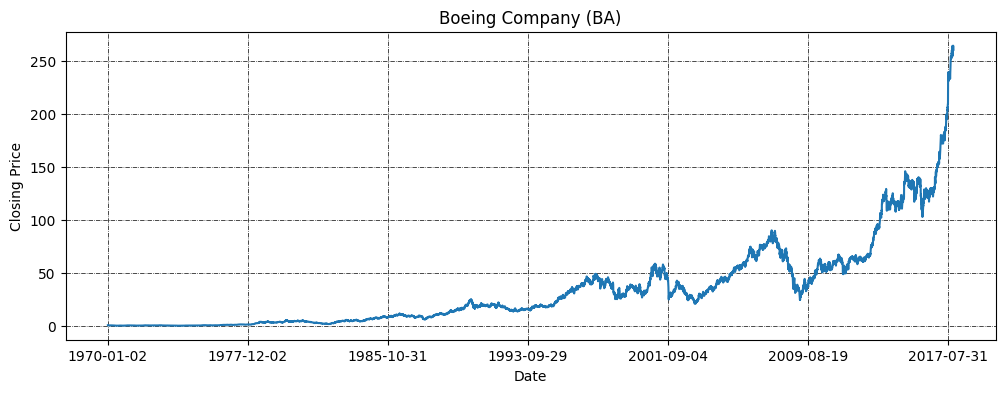

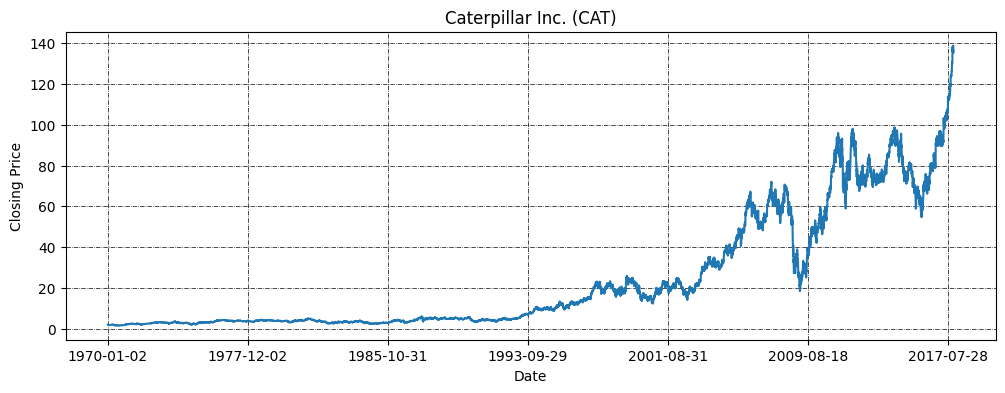

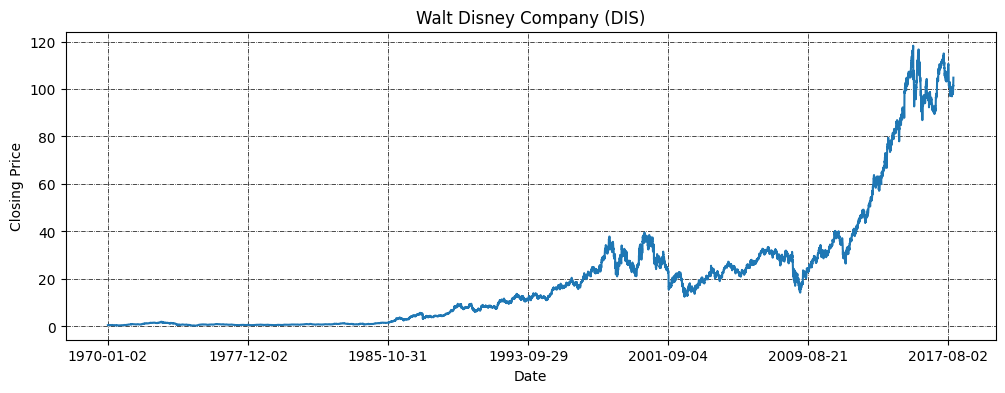

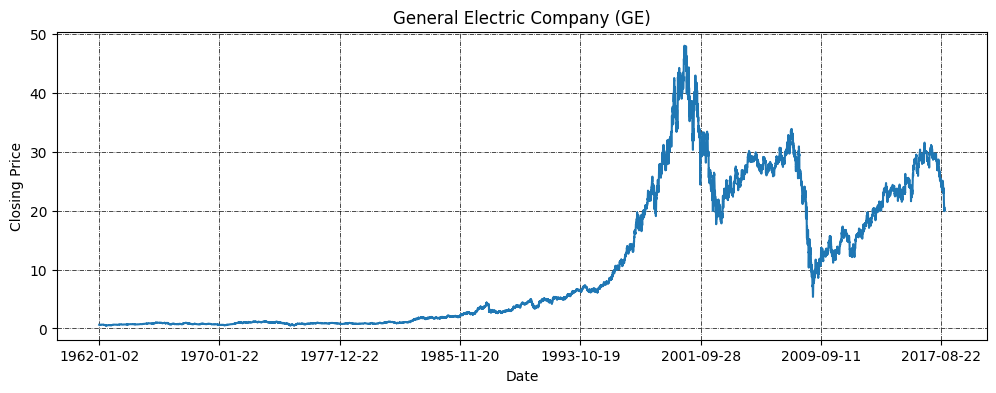

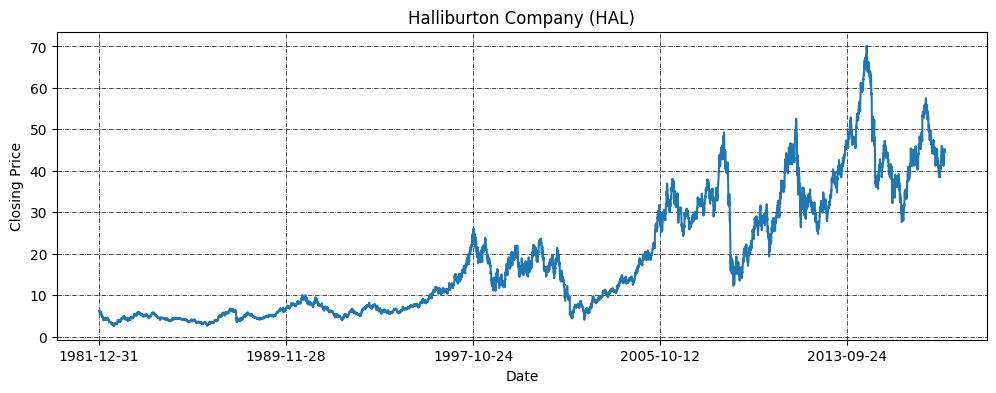

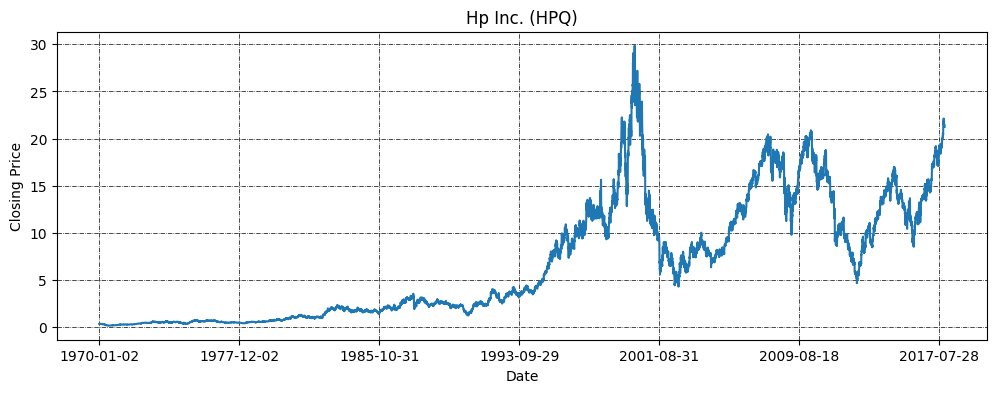

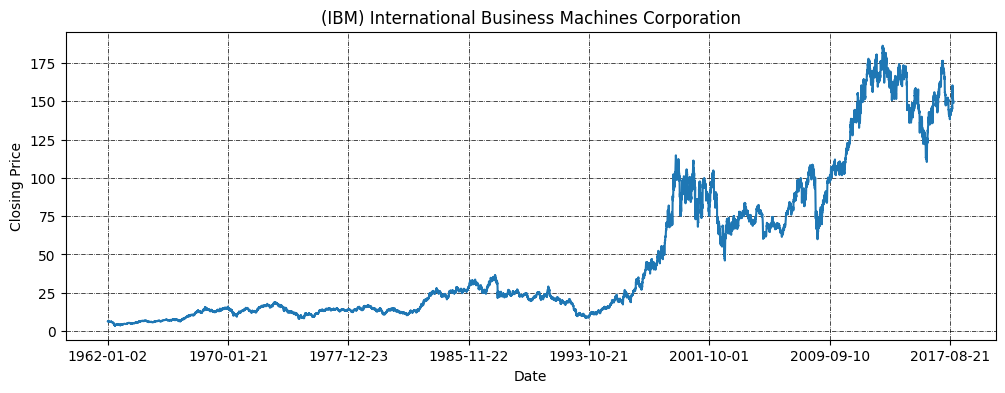

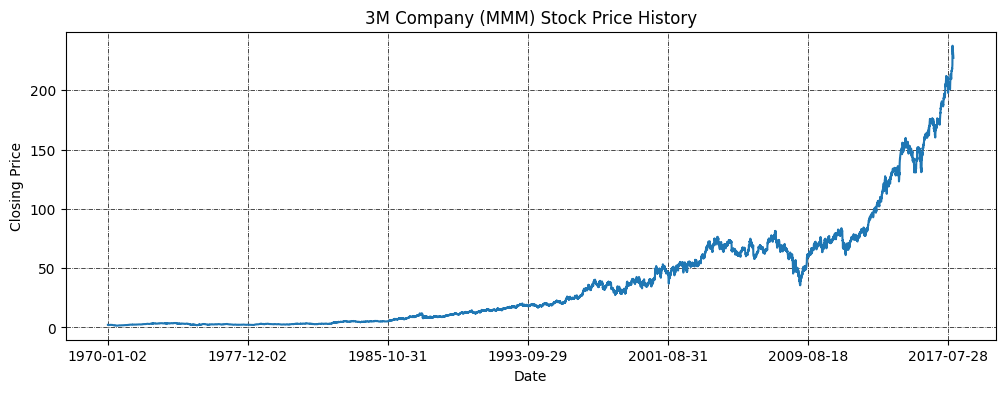

In [12]:
# plot the closing price for each stock
for i, inp in enumerate([inp0, inp1, inp2, inp3, inp4, inp5, inp6, inp7]):

    inp['Close'].plot(figsize=(12,4))

    plt.title(dfs[list(dfs.keys())[i]][0])
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.grid(which='major', color='k', linestyle='-.', linewidth=0.5)
    plt.show()

In [13]:
import plotly.graph_objs as go

# Create a list of traces for each stock
traces = []
for i, inp in enumerate([inp0, inp1, inp2, inp3, inp4, inp5, inp6, inp7]):
    trace = go.Scatter(x=inp.index, y=inp['Close'], name=dfs[list(dfs.keys())[i]][0])
    traces.append(trace)

# Create layout for the chart
layout = go.Layout(title='Closing Prices for Each Stock', xaxis=dict(title='Date'), yaxis=dict(title='Closing Price'))

# Create figure and plot the chart
fig = go.Figure(data=traces, layout=layout)
fig.show()


* c.] Create a function that loads the closing prices from a data file into numpy arrays that are appropriate for training time sequence models to predict a price two days into the future, using a lookback value of your choice.

d.] Use the function created in the previous step to load all of the data files into 2d numpy arrays.

In [14]:
# extracting the values of the closing price for each stock
ts_data_inp0 = inp0['Close'].values.reshape(-1,1)
ts_data_inp1 = inp1['Close'].values.reshape(-1,1)
ts_data_inp2 = inp2['Close'].values.reshape(-1,1)
ts_data_inp3 = inp3['Close'].values.reshape(-1,1)
ts_data_inp4 = inp4['Close'].values.reshape(-1,1)
ts_data_inp5 = inp5['Close'].values.reshape(-1,1)
ts_data_inp6 = inp6['Close'].values.reshape(-1,1)
ts_data_inp7 = inp7['Close'].values.reshape(-1,1)

In [15]:
# scale the data
scaler = MinMaxScaler()

# first input we will use .fit_transform
inp0_scaled = scaler.fit_transform(inp0.Close.values.reshape(-1,1))

# the rest we will use .transform
inp1_scaled = scaler.transform(inp1.Close.values.reshape(-1,1))
inp2_scaled = scaler.transform(inp2.Close.values.reshape(-1,1))
inp3_scaled = scaler.transform(inp3.Close.values.reshape(-1,1))
inp4_scaled = scaler.transform(inp4.Close.values.reshape(-1,1))
inp5_scaled = scaler.transform(inp5.Close.values.reshape(-1,1))
inp6_scaled = scaler.transform(inp6.Close.values.reshape(-1,1))
inp7_scaled = scaler.transform(inp7.Close.values.reshape(-1,1))

In [16]:
# Training data
# setup the training data list
train_data = [inp0_scaled, inp1_scaled, inp2_scaled, inp3_scaled]

# train data
X_train = np.empty((0, look_back))
y_train = np.empty((0, 1))

X_train, y_train = prep_data(X_train, y_train, train_data, look_back=look_back, predict_days=predict_days)

---------- RESULTS ----------
shape: (50279, 20), (50279, 1)


In [17]:
# Validation data
# setup the validation data list
val_data = [inp4_scaled, inp5_scaled]

# validation data
X_val = np.empty((0, look_back))
y_val = np.empty((0, 1))

X_val, y_val = prep_data(X_val, y_val, val_data, look_back=look_back,predict_days=predict_days)


---------- RESULTS ----------
shape: (21118, 20), (21118, 1)


In [18]:
# Test data
# setup the training, validation and testing data list
test_data = [inp6_scaled, inp7_scaled]

# test data
X_test = np.empty((0, look_back))
y_test = np.empty((0, 1))

X_test, y_test = prep_data(X_test, y_test, test_data, look_back=look_back, predict_days=predict_days)

---------- RESULTS ----------
shape: (26134, 20), (26134, 1)


## 2. Modeling
* a.] Create and compile a time sequence model using tf.keras.Sequential. Use at least one Conv1d layer, one SimpleRNN layer, and one Dropout layer. Use mean_squared_error for the loss.

In [19]:

# instantiate the Sequential model
mod_1 = Sequential()
mod_1.add(Reshape((look_back,1), input_shape = (look_back,)))
mod_1.add(Conv1D(32, 3, activation='relu'))
mod_1.add(MaxPooling1D(2))
mod_1.add(SimpleRNN(32))
mod_1.add(Dropout(0.2))
mod_1.add(Dense(1))
mod_1.add(Activation('linear'))


In [20]:

# Compile the model
mod_1.compile(loss='mean_squared_error', optimizer='adam')
# show the model summary
mod_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 18, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 32)             0         
 D)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                        

* b.] Train the model on the training data without using a validation split. Calculate and record the training loss.

In [21]:
# fit the model

history_1 = mod_1.fit(X_train, y_train, epochs=20, batch_size=42)

Epoch 1/20
1198/1198 [==============================] - 32s 12ms/step - loss: 4.0111e-04
Epoch 2/20
1198/1198 [==============================] - 15s 12ms/step - loss: 1.6428e-04
Epoch 3/20
1198/1198 [==============================] - 14s 12ms/step - loss: 1.4631e-04
Epoch 4/20
1198/1198 [==============================] - 13s 11ms/step - loss: 1.6336e-04
Epoch 5/20
1198/1198 [==============================] - 14s 12ms/step - loss: 1.4486e-04
Epoch 6/20
1198/1198 [==============================] - 14s 11ms/step - loss: 1.3842e-04
Epoch 7/20
1198/1198 [==============================] - 15s 13ms/step - loss: 1.4096e-04
Epoch 8/20
1198/1198 [==============================] - 14s 11ms/step - loss: 1.4790e-04
Epoch 9/20
1198/1198 [==============================] - 14s 11ms/step - loss: 1.4785e-04
Epoch 10/20
1198/1198 [==============================] - 16s 13ms/step - loss: 1.4082e-04
Epoch 11/20
1198/1198 [==============================] - 14s 11ms/step - loss: 1.4095e-04
Epoch 12/20
1198/11

In [22]:
# create a dict for the model results
# this dictionary will be modified inside the functions get_train_loss and get_val_loss
model_results = {}
set_train_loss(history_1, model_results, 'mod_1')

Training loss (mod_1): 0.000136


c.] Use the model to make predictions on the validation data.
* Calculate and record the validation loss.
* Create scatter plots of the validation data that show the true price as well as the model predictions

In [23]:
# make predictions on the validation data
y_pred_1_val = mod_1.predict(X_val)

# append the predictions to the model results
model_results['mod_1']['y_pred_val'] = y_pred_1_val

660/660 [==============================] - 2s 2ms/step


In [24]:
y_pred_1_val.shape

(21118, 1)

In [25]:
# get the validation loss
set_val_loss(X_val, y_val, mod_1, model_results, 'mod_1')

Validation loss (mod_1): 0.00000842


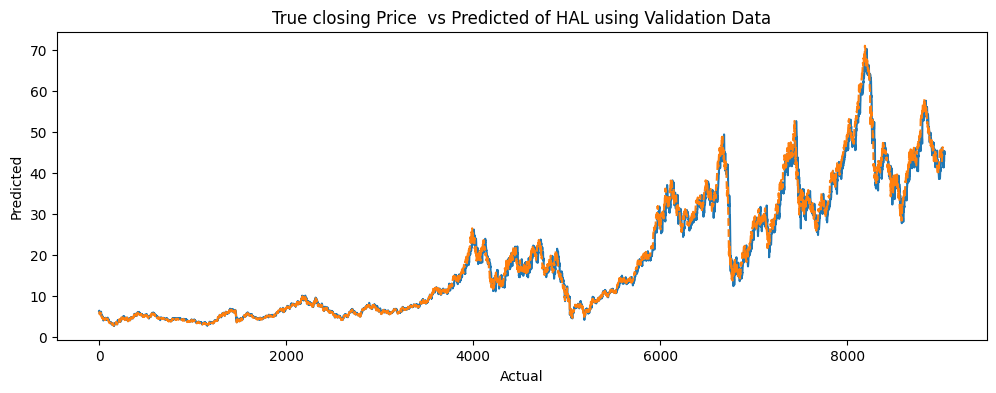

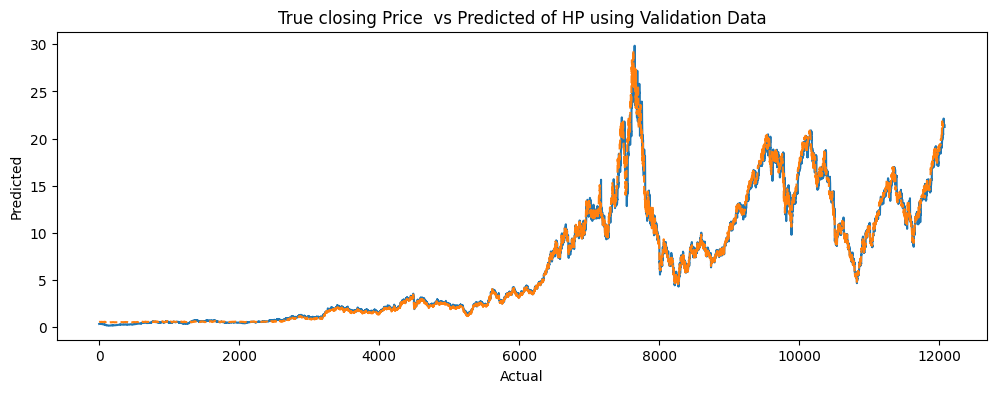

In [26]:
# plot the actual vs predicted values for the validation data
avp_plot_val(val_data, y_pred_1_val)


d.] Revisit the previous steps to make at least three models in total by changing architecture and hyperparameters.

In [27]:
model_2 = Sequential()
model_2.add(Reshape((look_back, 1), input_shape=(look_back, )))
model_2.add(LSTM(128, return_sequences=True))
model_2.add(LSTM(64, return_sequences=True))
model_2.add(Dropout(0.3))
model_2.add(Dense(1, activation='linear'))

# Using the Adam optimizer is a good choice
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed

model_2.compile(optimizer=optimizer, loss='mean_squared_error')


In [28]:
# fit the model
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=42)

Epoch 1/20
1198/1198 [==============================] - 12s 7ms/step - loss: 3.9794e-04
Epoch 2/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4692e-04
Epoch 3/20
1198/1198 [==============================] - 8s 6ms/step - loss: 1.4568e-04
Epoch 4/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4480e-04
Epoch 5/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4234e-04
Epoch 6/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4131e-04
Epoch 7/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4009e-04
Epoch 8/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4102e-04
Epoch 9/20
1198/1198 [==============================] - 8s 6ms/step - loss: 1.3858e-04
Epoch 10/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.4019e-04
Epoch 11/20
1198/1198 [==============================] - 8s 7ms/step - loss: 1.3943e-04
Epoch 12/20
1198/1198 [=================

In [29]:
# get the val loss
set_val_loss(X_val, y_val, model_2, model_results, 'model_2')

Validation loss (model_2): 0.00002183


In [30]:
# make predictions on the validation data for Model 2
y_pred_2_val = model_2.predict(X_val)

660/660 [==============================] - 3s 4ms/step


In [31]:

# append the predictions to the model results for Model 2
model_results['model_2']['y_pred_val'] = y_pred_2_val

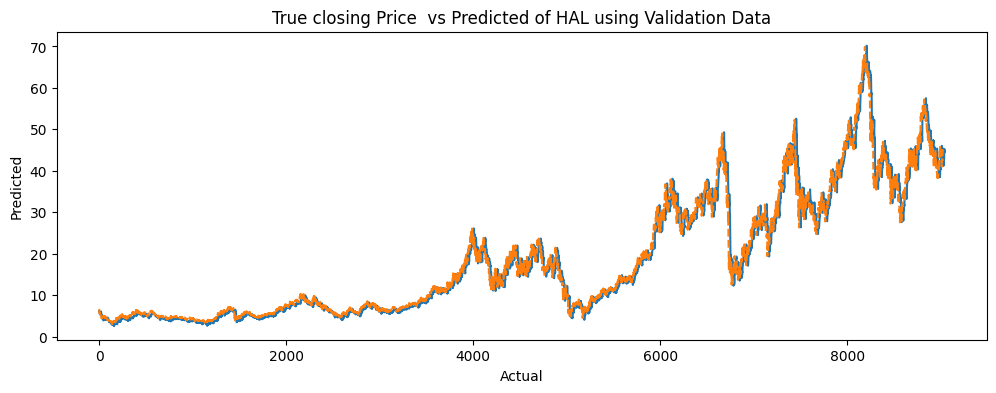

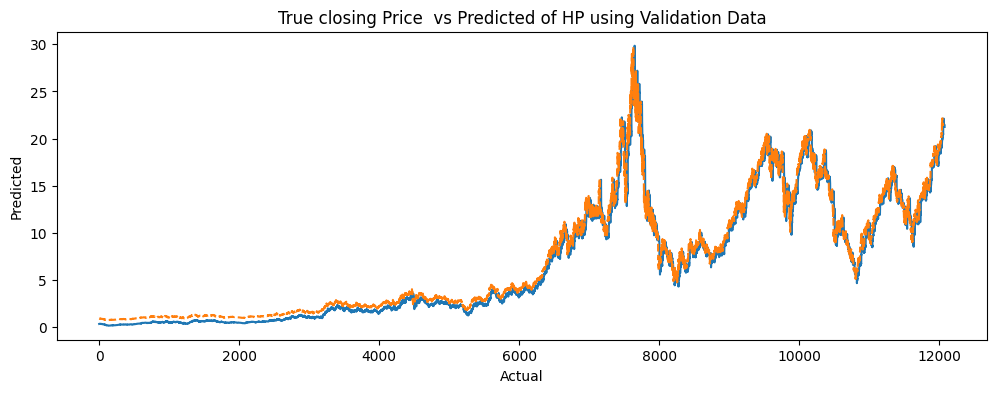

In [32]:
# plot the actual vs predicted values for the validation data for Model 2
# y_pred_2_val has shape (xxxx,xxx,xxx) so it must be transform into (xxx,xxx)
y_pred_2_val_modified = result = y_pred_2_val[:, 0, :]

avp_plot_val(val_data, y_pred_2_val_modified)

In [33]:
model_3 = Sequential()
model_3.add(Reshape((look_back, 1), input_shape=(look_back,)))
model_3.add(Conv1D(128, 3, activation='relu'))
model_3.add(MaxPooling1D(2))
model_3.add(SimpleRNN(64))
model_3.add(Dropout(0.3))
model_3.add(Dense(1, activation='linear'))

# Using the Adam optimizer is a good choice
optimizer = Adam(learning_rate=0.001)

model_3.compile(optimizer=optimizer, loss='mean_squared_error')


In [34]:
history_3 = model_3.fit(X_train, y_train, epochs=10, batch_size=42)

Epoch 1/10
1198/1198 [==============================] - 15s 11ms/step - loss: 2.5423e-04
Epoch 2/10
1198/1198 [==============================] - 14s 12ms/step - loss: 1.5370e-04
Epoch 3/10
1198/1198 [==============================] - 14s 11ms/step - loss: 1.4950e-04
Epoch 4/10
1198/1198 [==============================] - 14s 12ms/step - loss: 1.5387e-04
Epoch 5/10
1198/1198 [==============================] - 15s 13ms/step - loss: 1.5741e-04
Epoch 6/10
1198/1198 [==============================] - 23s 19ms/step - loss: 1.4835e-04
Epoch 7/10
1198/1198 [==============================] - 16s 13ms/step - loss: 1.4281e-04
Epoch 8/10
1198/1198 [==============================] - 20s 16ms/step - loss: 1.5020e-04
Epoch 9/10
1198/1198 [==============================] - 14s 11ms/step - loss: 1.3492e-04
Epoch 10/10
1198/1198 [==============================] - 13s 11ms/step - loss: 1.3767e-04


In [35]:
# get the training loss for Model 3
set_train_loss(history_3, model_results, 'model_3')
# get the validation loss for Model 3
set_val_loss(X_val, y_val, model_3, model_results, 'model_3')

Training loss (model_3): 0.000138
Validation loss (model_3): 0.00001881


In [36]:
# make predictions on the validation data for Model 3
y_pred_3_val = model_3.predict(X_val)

# append the predictions to the model results for Model 3
model_results['model_3']['y_pred_val'] = y_pred_3_val

660/660 [==============================] - 2s 2ms/step


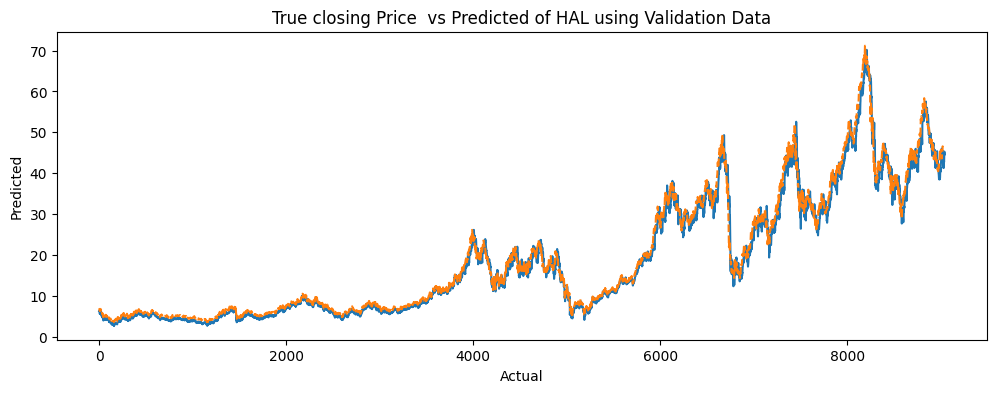

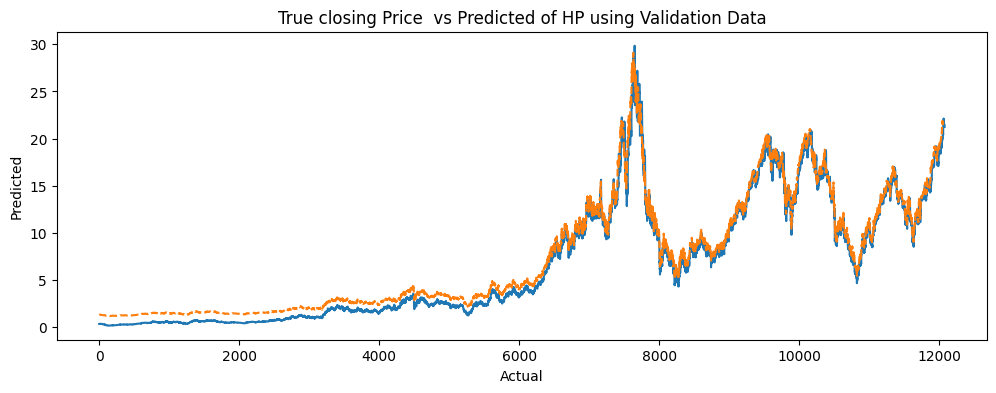

In [37]:

# plot the actual vs predicted values for the validation data for Model 3
avp_plot_val(val_data, y_pred_3_val)

In [38]:
model_4 = Sequential()
model_4.add(Reshape((look_back, 1), input_shape=(look_back, )))
model_4.add(LSTM(256, return_sequences=True))
model_4.add(LSTM(128, return_sequences=True))
model_4.add(LSTM(64, return_sequences=True))
model_4.add(Dropout(0.5))
model_4.add(Dense(1, activation='linear'))

# Using the Adam optimizer is a good choice
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate as needed

model_4.compile(optimizer=optimizer, loss='mean_squared_error')

In [39]:
history_4 = model_4.fit(X_train, y_train, epochs=15, batch_size=42)

Epoch 1/15
1198/1198 [==============================] - 15s 8ms/step - loss: 5.9373e-04
Epoch 2/15
1198/1198 [==============================] - 10s 8ms/step - loss: 3.1477e-04
Epoch 3/15
1198/1198 [==============================] - 10s 9ms/step - loss: 3.2699e-04
Epoch 4/15
1198/1198 [==============================] - 11s 9ms/step - loss: 3.0574e-04
Epoch 5/15
1198/1198 [==============================] - 10s 9ms/step - loss: 2.9122e-04
Epoch 6/15
1198/1198 [==============================] - 11s 9ms/step - loss: 3.1008e-04
Epoch 7/15
1198/1198 [==============================] - 10s 9ms/step - loss: 2.7984e-04
Epoch 8/15
1198/1198 [==============================] - 10s 8ms/step - loss: 2.8037e-04
Epoch 9/15
1198/1198 [==============================] - 10s 9ms/step - loss: 2.7467e-04
Epoch 10/15
1198/1198 [==============================] - 11s 9ms/step - loss: 2.6328e-04
Epoch 11/15
1198/1198 [==============================] - 10s 9ms/step - loss: 2.5455e-04
Epoch 12/15
1198/1198 [=======

In [40]:
# get the training loss for Model 4
set_train_loss(history_4, model_results, 'model_4')
# get the validation loss for Model 3
set_val_loss(X_val, y_val, model_4, model_results, 'model_4')

Training loss (model_4): 0.000231
Validation loss (model_4): 0.00003810


In [41]:
# make predictions on the validation data for Model 4
y_pred_4_val = model_4.predict(X_val)

# append the predictions to the model results for Model 4
model_results['model_4']['y_pred_val'] = y_pred_4_val

660/660 [==============================] - 4s 4ms/step


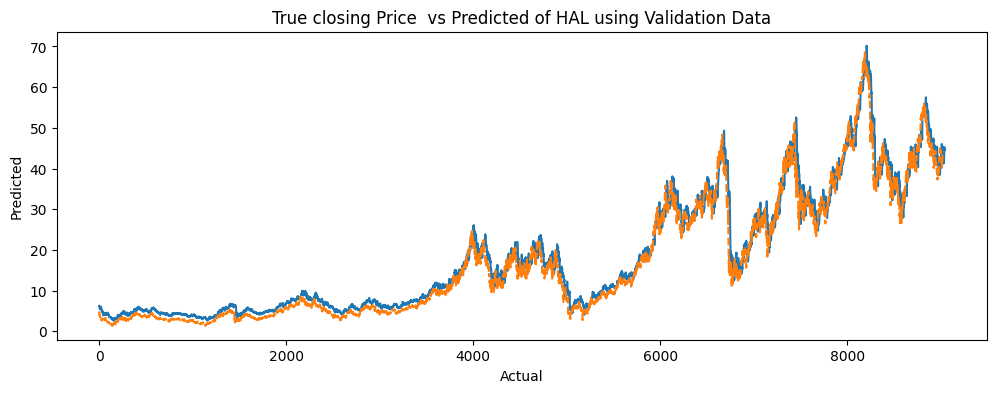

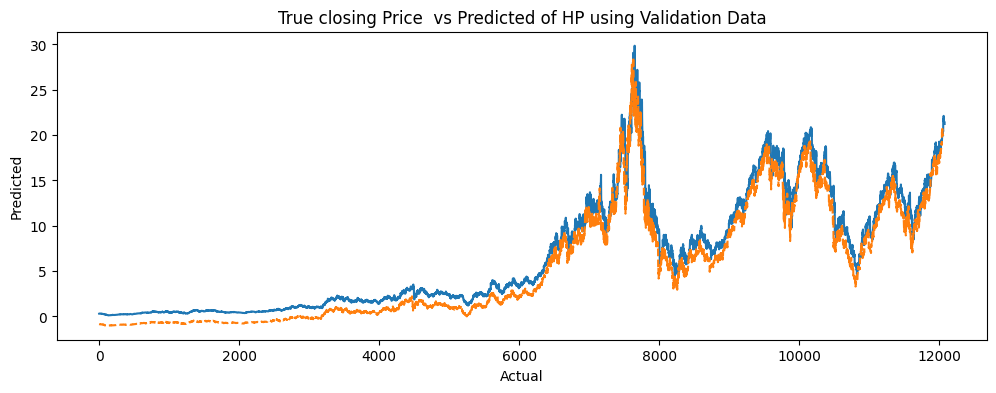

In [42]:
# plot the actual vs predicted values for the validation data for Model 4
y_pred_4_val_mod = result = y_pred_4_val[:, 0, :]
avp_plot_val(val_data, y_pred_4_val_mod)

e.] Once you are finished altering hyperparameters, present neatly the training and validation loss along with the scatter plots for each model showing predicted prices and actual prices. Choose the best model by comparing how each model did on training and validation data; provide your reasoning in markdown.

In [43]:
# Code used to identify the best model based on lower validation
best_model_key = None
best_val_loss = float('inf')

for key, value in model_results.items():
    if 'val_loss' in value:
        val_loss = value['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_key = key

# Check if a best model was found
if best_model_key:
    print(f"The best model is {best_model_key} with a validation loss of {best_val_loss:.8f}.")
else:
    print("No valid models found in model_results.")


The best model is mod_1 with a validation loss of 0.00000842.


In [44]:

best_model = model_results[best_model_key]['model']
best_model_test_pred = best_model.predict(X_test)
model_results[best_model_key]['y_pred_test'] = best_model_test_pred

# get the test loss
loss_test = best_model.evaluate(X_test, y_test, verbose=42)

817/817 [==============================] - 2s 3ms/step


In [45]:
# Print the best model and its test loss
print(f"The best model is {best_model_key} with a test loss of {loss_test:.6f}.")

The best model is mod_1 with a test loss of 0.000083.


f. ] With the best model, make predictions on the testing data; calculate the testing loss and present a scatter plot of the predictions along with the true values.

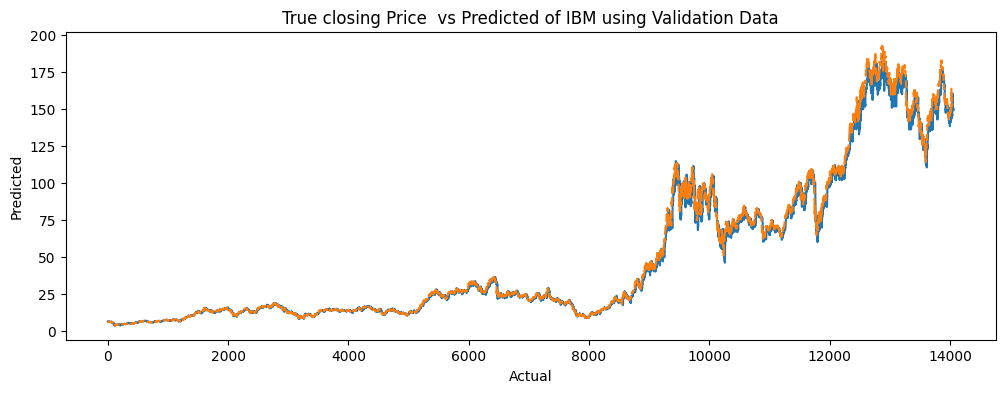

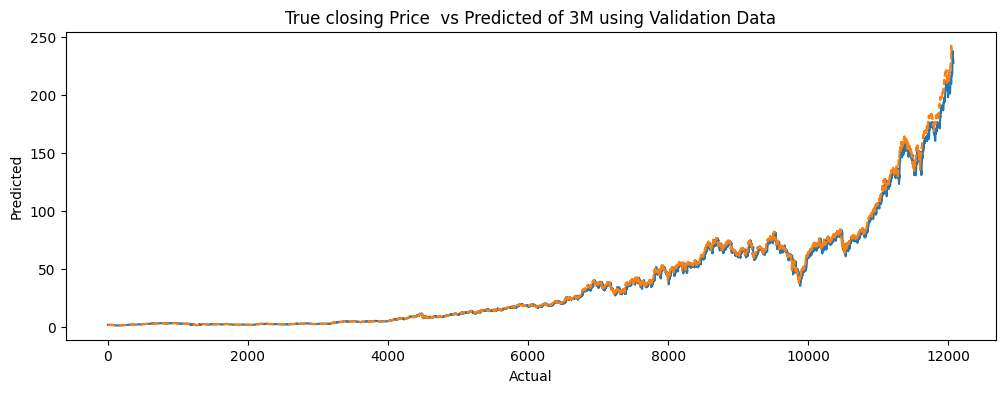

In [46]:
# Plot the actual vs. predicted values for the best model's validation and test data
test_preds = model_results[best_model_key]['y_pred_test']

if test_preds.shape.count == 3 :
  test_preds = model_results[best_model_key]['y_pred_test'][:, 0, :]

avp_plot_test(test_data, test_preds)

In [47]:
# predict many days in the future to show the flaw of this method

days_to_predict = 120

# predict two days in the future
prediction_data = X_test[len(X_test)-1:]

predicted_days = []

for d in range(days_to_predict):

  next_predicted_day = best_model.predict(prediction_data)
  _list = prediction_data.tolist()
  _list[0].append(next_predicted_day[0][0])
  _list[0].pop(0)
  prediction_data = np.array(_list)
  predicted_days.append(next_predicted_day[0][0])

1/1 [==============================] - 0s 18ms/step


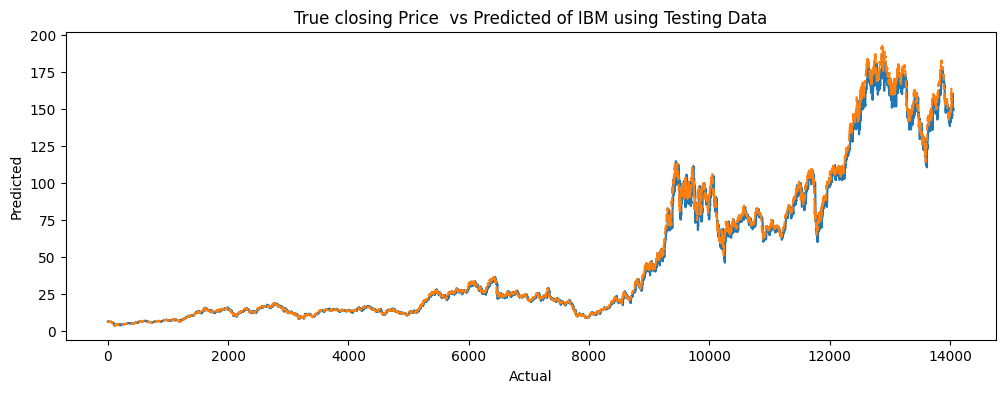

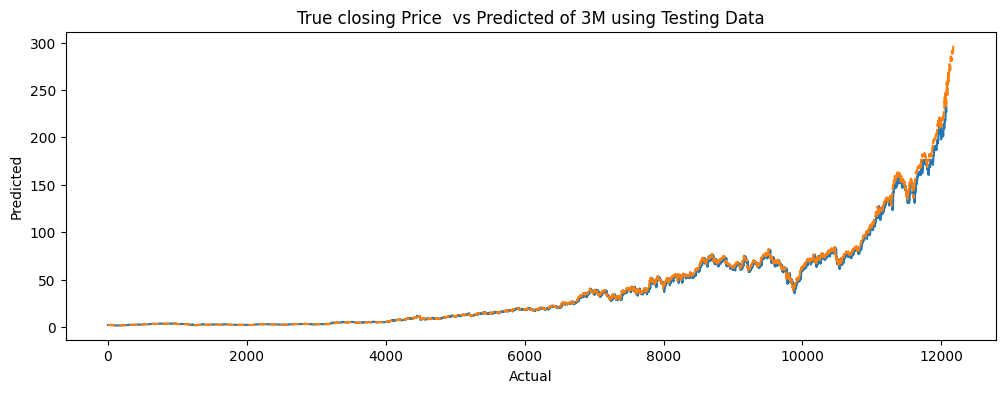

In [52]:

preds_as_list = test_preds.tolist()
preds_as_list.pop(len(test_preds) -1)

for i in predicted_days:
  preds_as_list.append([i])

updated_preds = np.array(preds_as_list)
avp_plot_test(test_data, updated_preds)

## 3. Discussion
* a.] Select the best model based on quantitative metrics and plots. Consider zooming-in on problem areas when comparing performance. Justify your selection using markdown.

* b.] Use markdown to describe how well you feel your model would work to predict closing stock prices two days into the future. Give a quantitative estimate of the error in the predictions.

In [49]:
model_results

{'mod_1': {'train_loss': 0.00013628749002236873,
  'y_pred_val': array([[0.0007445 ],
         [0.01448341],
         [0.01715262],
         ...,
         [0.08074399],
         [0.08071816],
         [0.08046834]], dtype=float32),
  'model': <keras.src.engine.sequential.Sequential at 0x7dc33e7d3100>,
  'val_loss': 8.423388862865977e-06,
  'y_pred_test': array([[7.4449927e-04],
         [1.4645167e-02],
         [1.7373525e-02],
         ...,
         [9.0328646e-01],
         [8.9978594e-01],
         [8.9808404e-01]], dtype=float32)},
 'model_2': {'val_loss': 2.183018841606099e-05,
  'model': <keras.src.engine.sequential.Sequential at 0x7dc320185270>,
  'y_pred_val': array([[[0.00217238],
          [0.00279868],
          [0.00249971],
          ...,
          [0.0014116 ],
          [0.00137492],
          [0.00134224]],
  
         [[0.02404325],
          [0.00196864],
          [0.00257814],
          ...,
          [0.00140862],
          [0.00137004],
          [0.00133632]],
 

In [56]:
# Code used to identify the best model based on lower validation
best_model_key = None
best_val_loss = float('inf')

for key, value in model_results.items():
    if 'val_loss' in value:
        val_loss = value['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_key = key

# Check if a best model was found
if best_model_key:
    print(f"The best model is {best_model_key} with a validation loss of {best_val_loss:.8f}.")
else:
    print("No valid models found in model_results.")

best_model = model_results[best_model_key]['model']
best_model_test_pred = best_model.predict(X_test)
model_results[best_model_key]['y_pred_test'] = best_model_test_pred

# get the test loss
loss_test = best_model.evaluate(X_test, y_test, verbose=42)
# Print the best model and its test loss
print(f"The best model is {best_model_key} with a test loss of {loss_test:.6f}.")

The best model is mod_1 with a validation loss of 0.00000842.
817/817 [==============================] - 2s 2ms/step
The best model is mod_1 with a test loss of 0.000083.


In [57]:
import pandas as pd

# Code to identify the best model and its testing loss
best_model_key = None
best_val_loss = float('inf')

for key, value in model_results.items():
    if 'val_loss' in value:
        val_loss = value['val_loss']
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_key = key

if best_model_key:
    best_model = model_results[best_model_key]['model']
    best_model_test_pred = best_model.predict(X_test)
    model_results[best_model_key]['y_pred_test'] = best_model_test_pred

    loss_test = best_model.evaluate(X_test, y_test, verbose=42)
else:
    loss_test = None

# Create a DataFrame
df = pd.DataFrame({
    'Best Model': [best_model_key],
    'Validation Loss': [best_val_loss],
    'Testing Loss': [loss_test]
})

# Print the DataFrame
print(df)


817/817 [==============================] - 3s 3ms/step
  Best Model  Validation Loss  Testing Loss
0      mod_1         0.000008      0.000083


In [58]:
df

,Best Model,Validation Loss,Testing Loss
0,mod_1,0.000008,0.000083


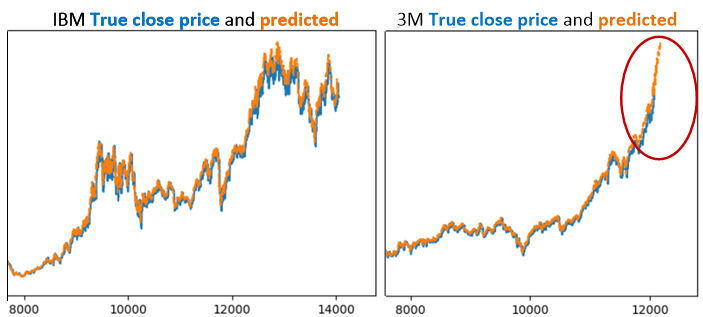

**Comments:**

Among the three LSTM models developed with distinct hyperparameters, Model 1 stands out as the most promising choice due to its superior performance. This conclusion is based on a comprehensive evaluation of training and validation loss.

Model 1 demonstrates the lowest loss across both training and validation datasets. Although this could suggest a risk of overfitting, further examination reveals valuable insights. In particular, the validation loss in Model 1 is notably lower than the testing loss. This divergence indicates the model's ability to capture underlying patterns and generalize from the training data effectively.

However, there is an important caveat when considering the model's predictive capabilities. When tasked with forecasting more than a short-term horizon, such as 10 or 120 days ahead, Model 1 exhibits limitations. This is evident from the final graph, where the model's predictions sharply deviate from real-world dynamics. Specifically, it tends to project unrealistic growth trends, indicating a lack of adaptability to long-term patterns. Such limitations emphasize the importance of careful model selection and understanding the extent to which the model's predictions remain reliable beyond its training context.

In summary, Model 1 shows strong promise as the best choice based on its performance in capturing short-term patterns, but its limitations in long-term forecasting should be considered in practical applications, particularly when projecting beyond the training data's scope

